# Automated Image Analysis: Diatoms & Infection Status

Below, I have made three main modifications to the existing diatom parasite analysis protocol:
1) Conversion of continuous (0-255) blue and red color channel values to binary (0 or 255) values based on whether pixel intensities pass a threshold
2) Conversion of RGB (3-dimensional) to grayscale (2-dimensional) array by taking the maximum of the red and blue pixel value (the grayscale matrix pixel values are also 0 or 255)
3) Use of Hough Line transformation algorithm to model cells as lines, rather than more abstract shapes

## Load packages

In [1]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from skimage import filters
import skimage
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

## Read in Images in RGB 

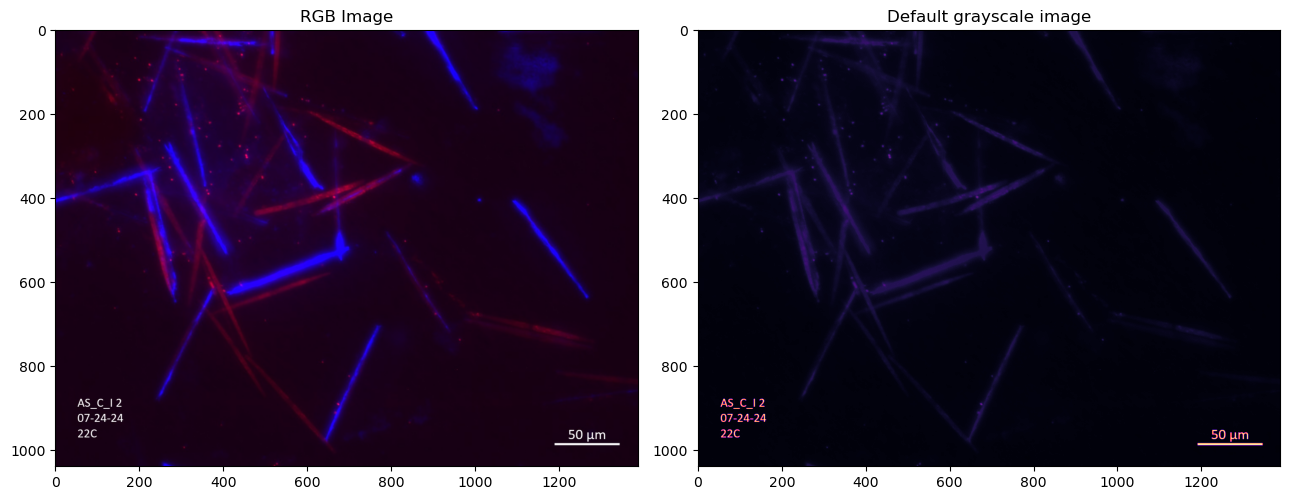

In [2]:

# image = cv2.imread("../images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # wd filepath
image = cv2.imread("../data/images/ClumpyLate_AS_C_I_22_2_20240724.jpg") # GH filepath

# Step 1: Convert to grayscale and RGB
    # read in greyscale/bw
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # read in RGB version
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Basic Edge Detection")
ax[0].imshow(image_rgb, cmap='magma')
ax[1].imshow(gray, cmap='magma')
    # set the title to all subplots
ax[0].set_title("RGB Image")
ax[1].set_title("Default grayscale image")
    # adjust spacing
fig.tight_layout()

By default, the grayscale image is a bit hard to see and blue cells are often easier to detect than red cells.  We will tackle these issues below.

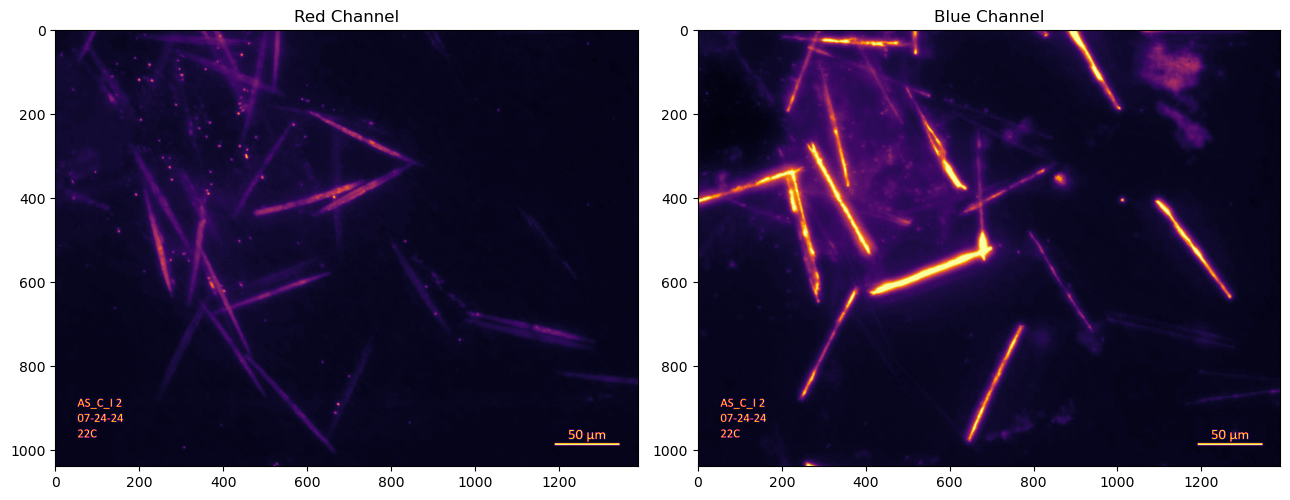

In [3]:
# extract RGB channels
red_channel = np.copy(image_rgb[:, :, 0])
green_channel = np.copy(image_rgb[:, :, 1])
blue_channel = np.copy(image_rgb[:, :, 2])

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Channels")
ax[0].imshow(red_channel, cmap='inferno')
ax[1].imshow(blue_channel, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Red Channel")
ax[1].set_title("Blue Channel")
    # adjust spacing
fig.tight_layout()


## Determine suitable thresholds for red and blue color channels

Above, it is clear that the red color channel tends to have lower intensity than the blue, so we should probably set a lower threshold for this array.  Let's play around with some different pixel intensity thresholds:

#### Blue channel:

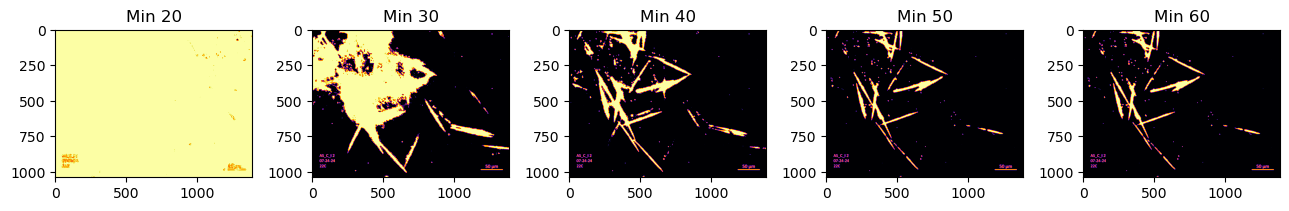

In [4]:

mask = np.zeros_like(gray)
_, red_mask_1 = cv2.threshold(red_channel, 20, 255, cv2.THRESH_BINARY) 
red_in_cells_1 = cv2.bitwise_and(red_mask_1, red_mask_1, mask=mask)
_, red_mask_2 = cv2.threshold(red_channel, 30, 255, cv2.THRESH_BINARY) 
red_in_cells_2 = cv2.bitwise_and(red_mask_2, red_mask_2, mask=mask)
_, red_mask_3 = cv2.threshold(red_channel, 40, 255, cv2.THRESH_BINARY) 
red_in_cells_3 = cv2.bitwise_and(red_mask_3, red_mask_3, mask=mask)
_, red_mask_4 = cv2.threshold(red_channel, 50, 255, cv2.THRESH_BINARY) 
red_in_cells_4 = cv2.bitwise_and(red_mask_4, red_mask_4, mask=mask)
_, red_mask_5 = cv2.threshold(red_channel, 60, 255, cv2.THRESH_BINARY) 
red_in_cells_5 = cv2.bitwise_and(red_mask_5, red_mask_5, mask=mask)


# plotting
fig, ax = plt.subplots(1, 5, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Masks")
ax[0].imshow(red_mask_1, cmap='inferno')
ax[1].imshow(red_mask_2, cmap='inferno')
ax[2].imshow(red_mask_3, cmap='inferno')
ax[3].imshow(red_mask_4, cmap='inferno')
ax[4].imshow(red_mask_4, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Min 20")
ax[1].set_title("Min 30" )
ax[2].set_title("Min 40" )
ax[3].set_title("Min 50" )
ax[4].set_title("Min 60" )


    # adjust spacing
fig.tight_layout()

#### Red channel:

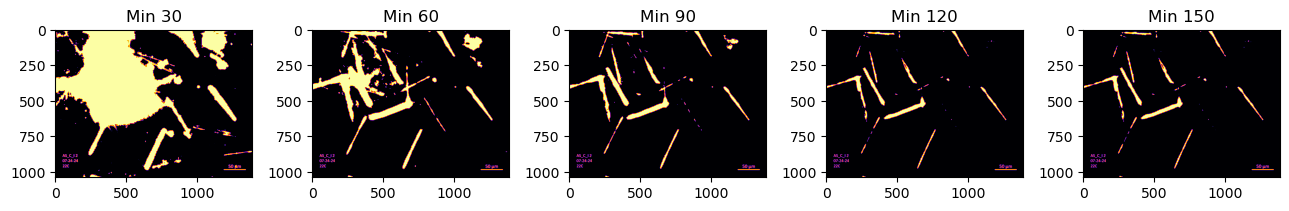

In [5]:
mask = np.zeros_like(gray)
_, blue_mask_1 = cv2.threshold(blue_channel, 30, 255, cv2.THRESH_BINARY) 
blue_in_cells_1 = cv2.bitwise_and(blue_mask_1, blue_mask_1, mask=mask)
_, blue_mask_2 = cv2.threshold(blue_channel, 60, 255, cv2.THRESH_BINARY) 
blue_in_cells_2 = cv2.bitwise_and(blue_mask_2, blue_mask_2, mask=mask)
_, blue_mask_3 = cv2.threshold(blue_channel, 90, 255, cv2.THRESH_BINARY)
blue_in_cells_3 = cv2.bitwise_and(blue_mask_3, blue_mask_3, mask=mask)
_, blue_mask_4 = cv2.threshold(blue_channel, 120, 255, cv2.THRESH_BINARY) 
blue_in_cells_4 = cv2.bitwise_and(blue_mask_4, blue_mask_4, mask=mask)
_, blue_mask_5 = cv2.threshold(blue_channel, 150, 255, cv2.THRESH_BINARY) 
blue_in_cells_5 = cv2.bitwise_and(blue_mask_5, blue_mask_5, mask=mask)


# plotting
fig, ax = plt.subplots(1, 5, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Masks")
ax[0].imshow(blue_mask_1, cmap='inferno')
ax[1].imshow(blue_mask_2, cmap='inferno')
ax[2].imshow(blue_mask_3, cmap='inferno')
ax[3].imshow(blue_mask_4, cmap='inferno')
ax[4].imshow(blue_mask_4, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Min 30")
ax[1].set_title("Min 60" )
ax[2].set_title("Min 90" )
ax[3].set_title("Min 120" )
ax[4].set_title("Min 150" )


    # adjust spacing
fig.tight_layout()

Based on the above, I will use a threshold of 50 for the red channel and 100 for the blue.  It is important to note that these values probably will not be suitable for all images, so an automated method for detection of a suitable threshold is needed.

In [6]:
# set thresholds
red_channel[red_channel<50]=0
red_channel[red_channel>=50]=255
blue_channel[blue_channel<100]=0
blue_channel[blue_channel>=100]=255

Text(0.5, 1.0, 'Blue channel')

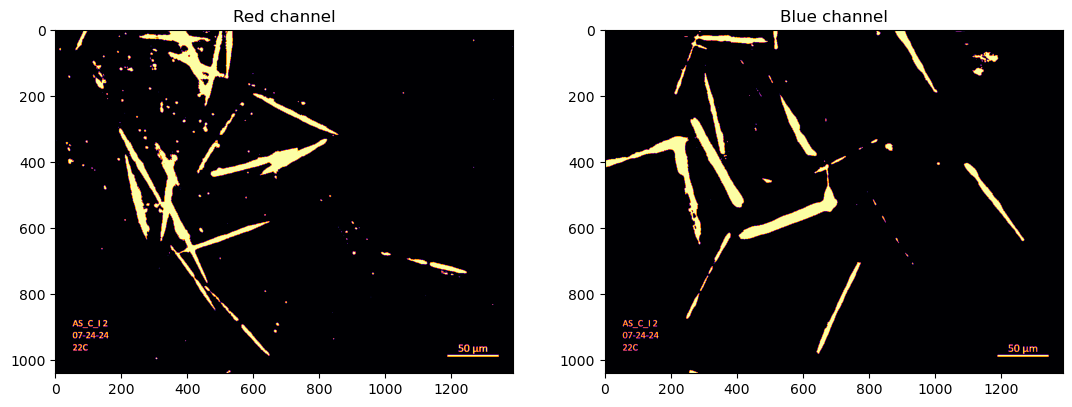

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(13, 10))
    # set main title
# plt.suptitle("Color Masks")
ax[0].imshow(red_channel, cmap='inferno')
ax[1].imshow(blue_channel, cmap='inferno')
    # set the title to all subplots
ax[0].set_title("Red channel")
ax[1].set_title("Blue channel" )

Now the red and blue channels are either 0 or 255 at each pixel.  We will encode the gray array as the maximum of the red and blue pixel values at each coordinate.

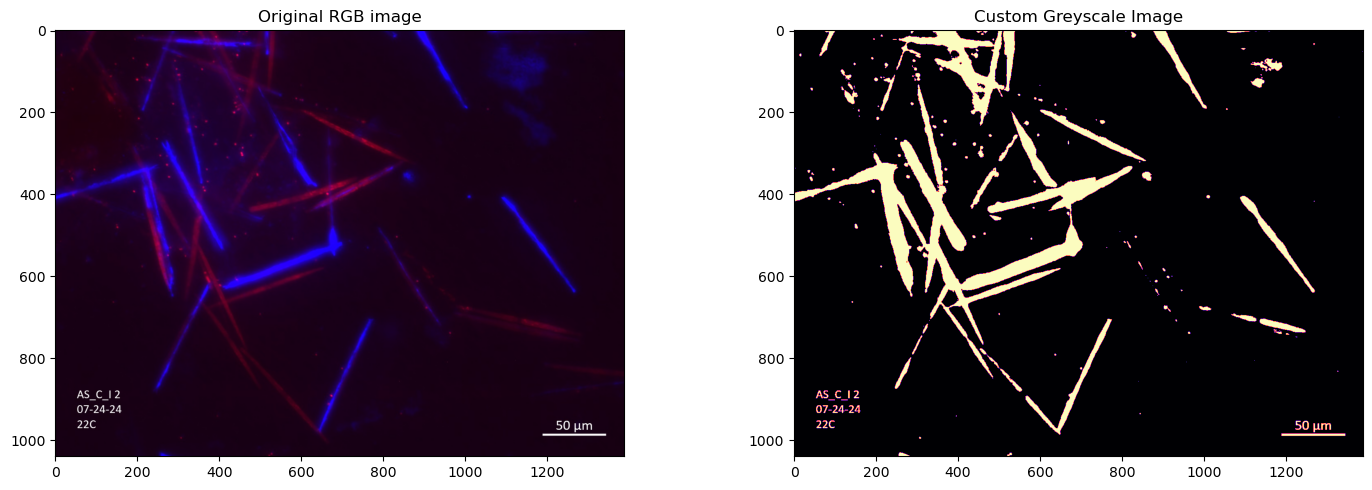

In [8]:
custom_gray=[]
for i,row in enumerate(red_channel):
    custom_gray.append([])
    for j,col in enumerate(row):
        if red_channel[i,j]>blue_channel[i,j]:
            custom_gray[-1].append(red_channel[i,j]*255)
        else:
            custom_gray[-1].append(blue_channel[i,j]*255)
custom_gray=np.array(custom_gray)
custom_gray=custom_gray.astype(np.uint8)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].imshow(image_rgb, cmap='magma')
ax[1].imshow(custom_gray, cmap='magma')

ax[0].set_title("Original RGB image")
ax[1].set_title("Custom Greyscale Image")
    # adjust spacing
fig.tight_layout()

## Detect lines in the new image

I believe we can take advantage of the long, thin shape of these cells by modelling them as lines.  This approach uses the Hough line transform. Note that this algorithm has an unfortunate tendency to make lots of parallel lines when a thick line is supplied.  In order to circumvent this, I am downscaling the images to 160*120 pixels before inputting them to the model.  Some playing with these dimensions as well as the parameters to the HoughLinesP function would be recommended.

In [10]:
backup=np.copy(image_rgb)

28 cells detected.


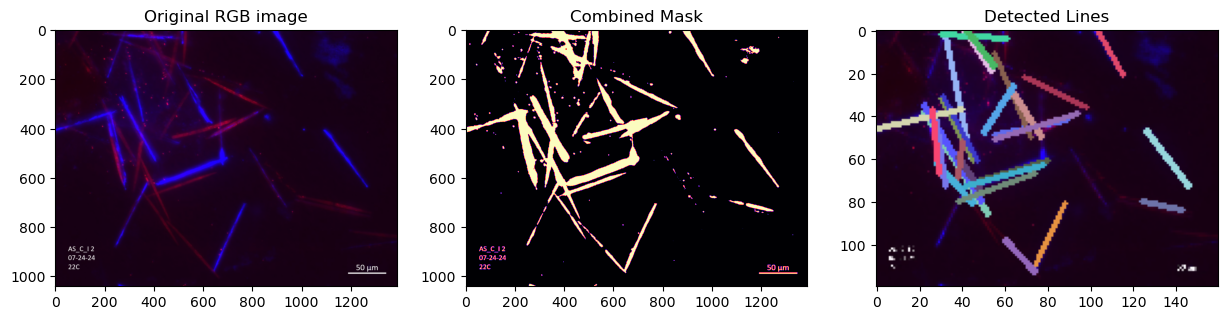

In [18]:
x_size,y_size=160,120

image=cv2.resize(backup,(x_size, y_size))
img = np.copy(cv2.resize(custom_gray,(x_size, y_size)))

edges = cv2.resize(custom_gray,(x_size, y_size))

lines_list =[]
lines = cv2.HoughLinesP(
            edges, # Input edge image
            1, # Distance resolution in pixels
            np.pi/180, # Angle resolution in radians
            threshold=30, # Min number of votes for valid line
            minLineLength=15, # Min allowed length of line
            maxLineGap=5 # Max allowed gap between line for joining them
            )

for points in lines:
    x1,y1,x2,y2=points[0]
    cv2.line(image,(x1,y1),(x2,y2),(np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)),2)#Give each line a different random color and draw on original image
    lines_list.append([(x1,y1),(x2,y2)])

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_rgb, cmap='magma')
ax[1].imshow(custom_gray, cmap='magma')
ax[2].imshow(image, cmap='magma')

ax[0].set_title("Original RGB image")
ax[1].set_title("Combined Mask") #Custom Greyscale Image
ax[2].set_title("Detected Lines")
    # adjust spacing

print(f"{len(lines)} cells detected.")

The line detection works reasonably well, although there are some cells which did not pass our initial intensity thresholds being missed.  A more annoying issue is the tendency for many cells to be double-counted: if this approach is used further, at some point it will be necessary to merge overlapping lines if they exhibit similar slopes or start and stop coordinates.

## Extract coordinates of the found lines and calculate the pixel ratios of the appropriate regions

Note that when mapping the line coordinates back to the original image, we must multiply coordinates by the same ratio that was used to downscale the image initially.  Currently this calculation uses the binary converted red and blue color channels (i.e. the arrays where pixel values are only 0 or 255) and may be overvaluing the red channel as a result.  Depending on the desired output it may be preferable to go back to the original pixel values or just decide on thresholds for what is considered an uninfected, partially infected and fully infected cell.  For now I am just going to declare anything with a blue/red ratio below 0.2 to be uninfected.  Given the fact that many infected and uninfected cells are overlapping, we probably can't require the proportion of blue in a segmented cell to be much lower than this to term it uninfected.  In the segmented images, these overlapping regions show up as a bright blue dot in an otherwise red cell. Given that this algorithm is still much worse than manual annotation, it may be desirable to ignore cells with an intermediate color ratio, or those overlapping many other cells, as these are bound to be less confident observations.

In [19]:
original_x_size,original_y_size=1388,1040

all_coordinates=[]
img=np.zeros((original_y_size, original_x_size),np.uint8)
for line in lines: 
    temp_red=red_channel.copy()
    temp_blue=blue_channel.copy()
    
    x1,y1,x2,y2=int(line[0][0]*original_y_size/y_size),int(line[0][1]*original_x_size/x_size),int(line[0][2]*original_y_size/y_size),int(line[0][3]*original_x_size/x_size)
    img=np.zeros((original_y_size, original_x_size),np.uint8)
    cv2.line(img,(x1,y1),(x2,y2),255,20)#draw a thickness 20 line where the cell was found
    coords = np.argwhere(img)#gets coordinates of all nonzero points i.e. where we just drew a line - this is the cell mask
    all_coordinates.append([f"{val[0]}_{val[1]}" for val in coords])

/var/folders/0k/7fxmyg7978b38fh93gct569c0000gn/T/ipykernel_30989/516136070.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


I count 17 infected and 11 uninfected cells.


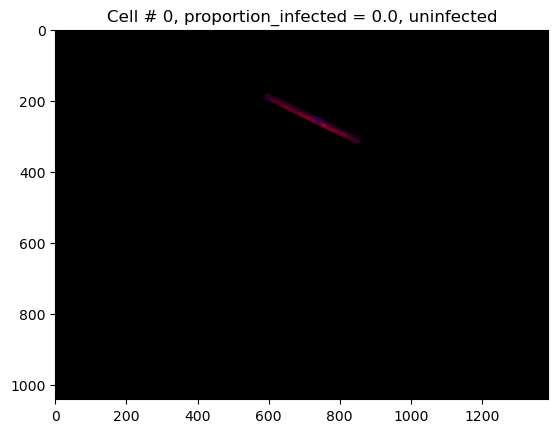

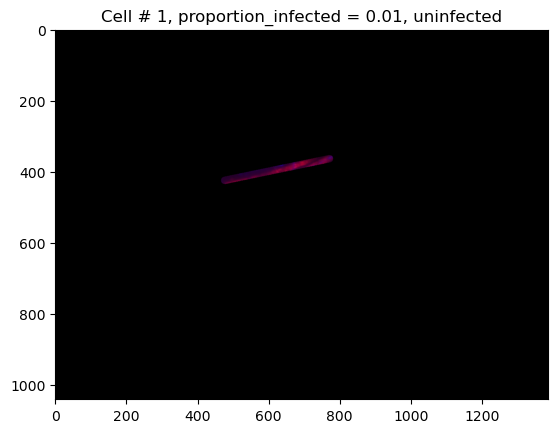

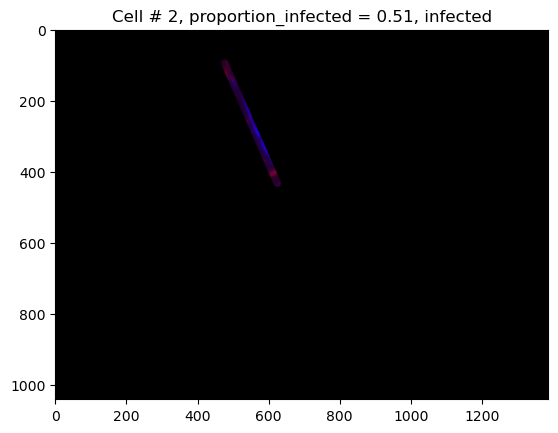

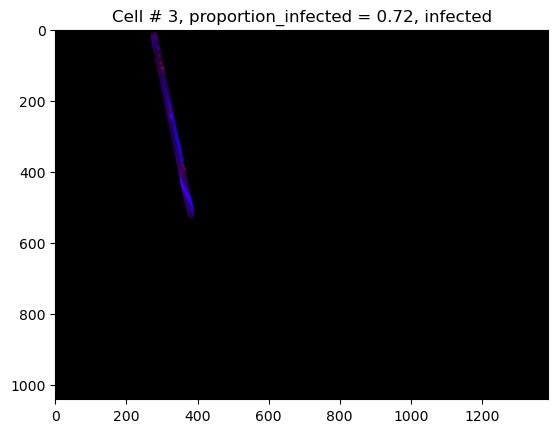

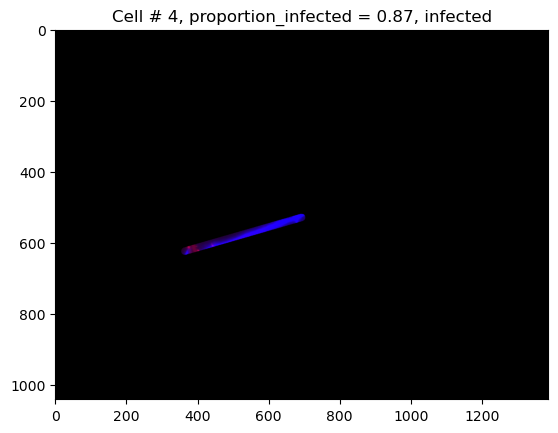

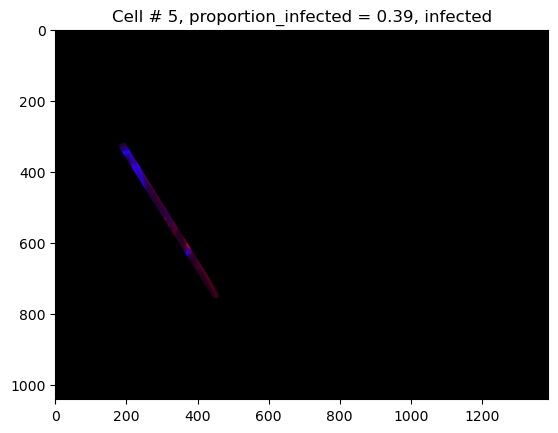

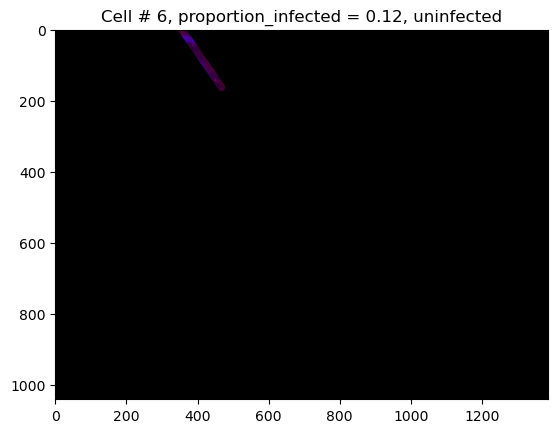

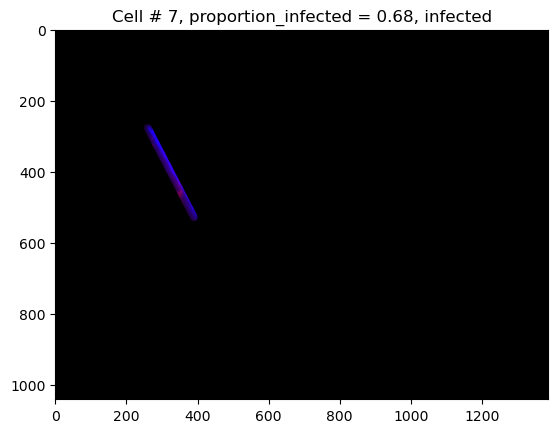

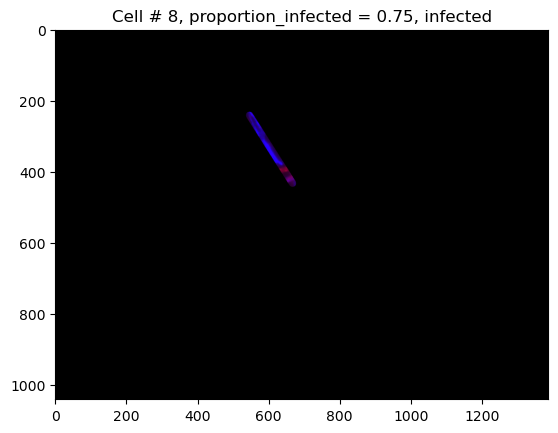

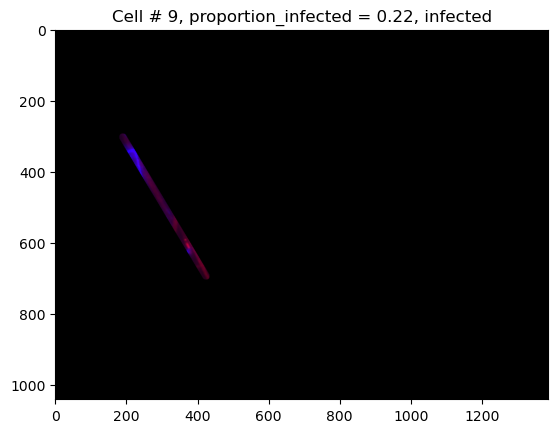

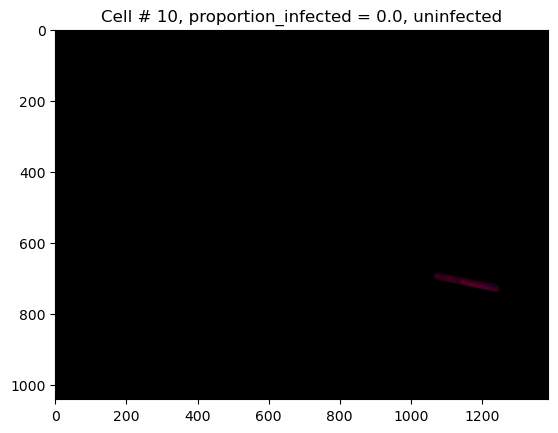

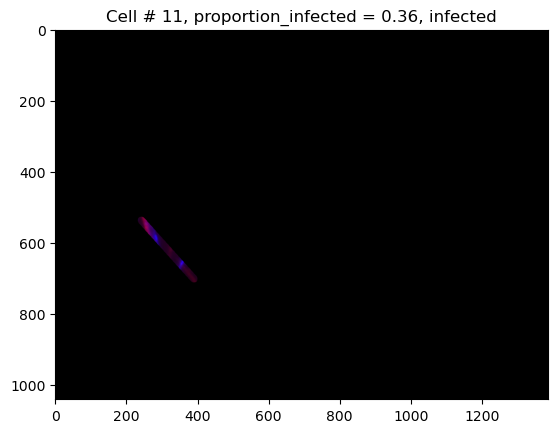

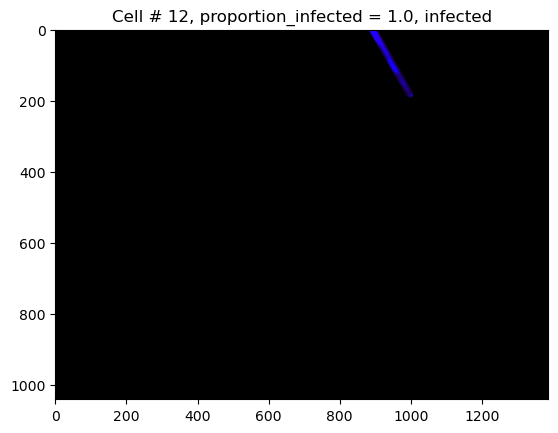

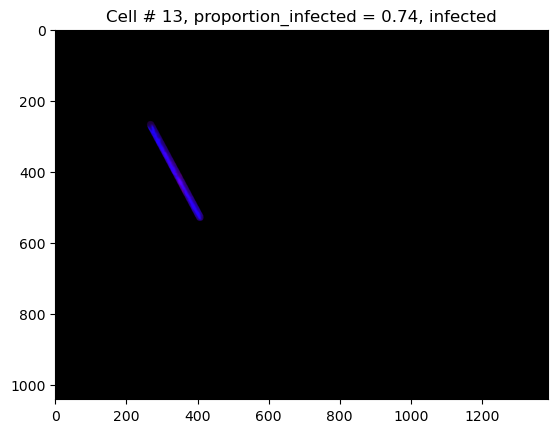

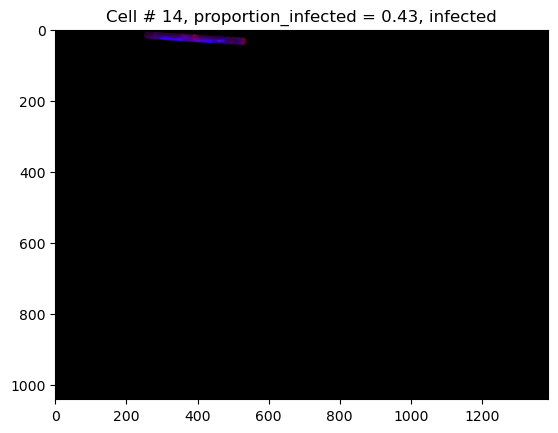

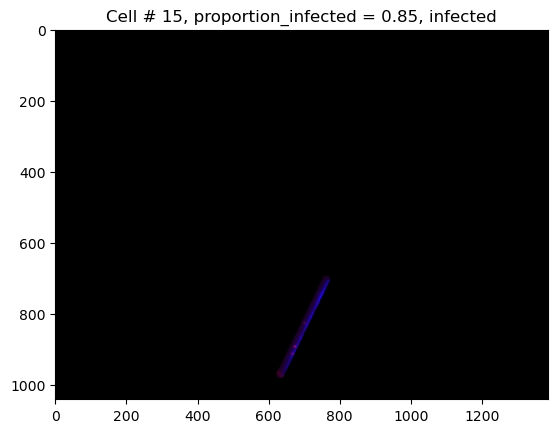

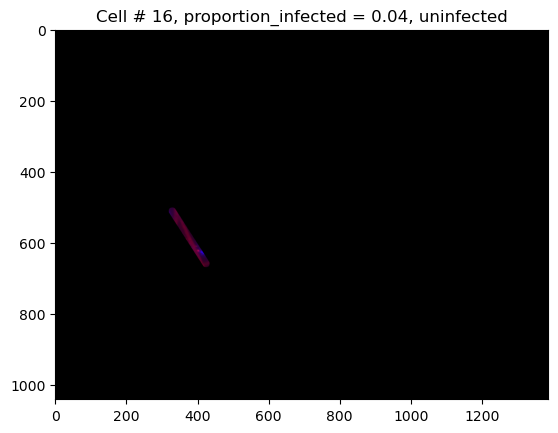

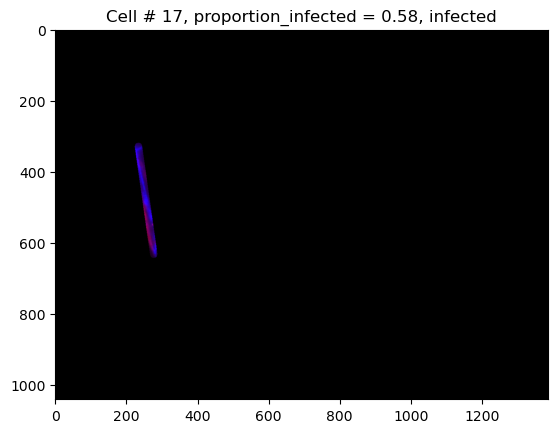

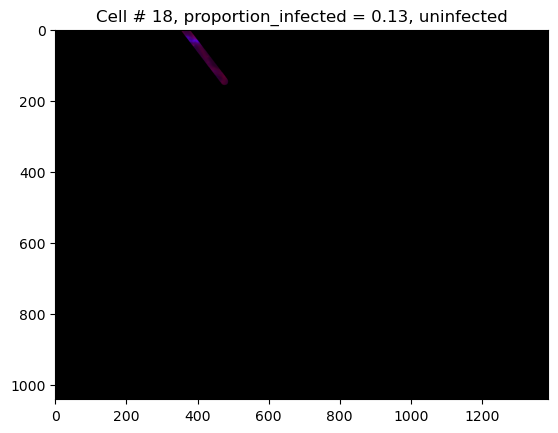

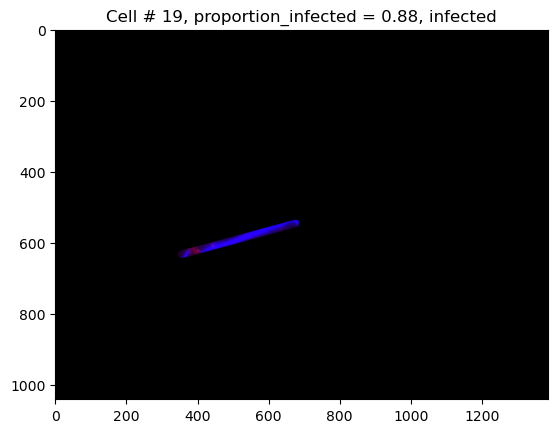

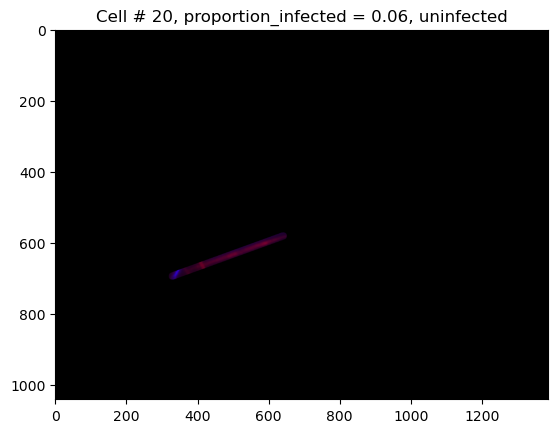

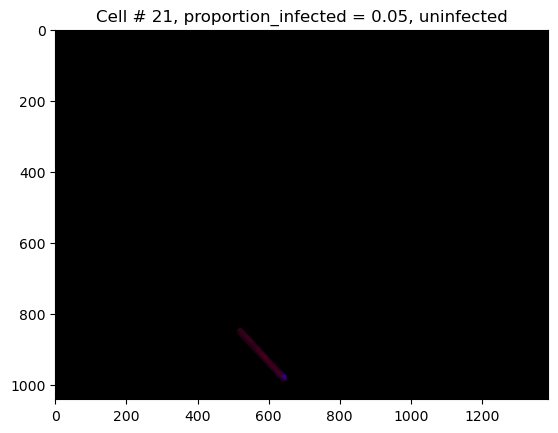

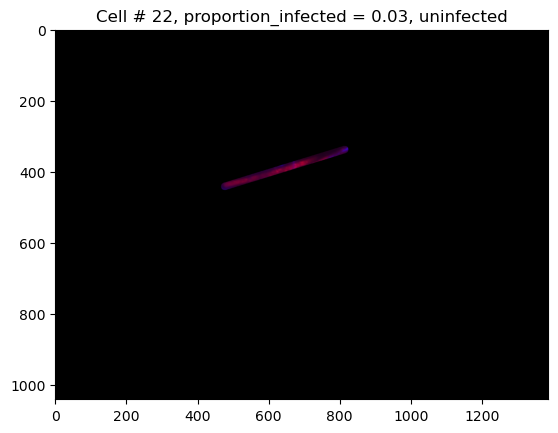

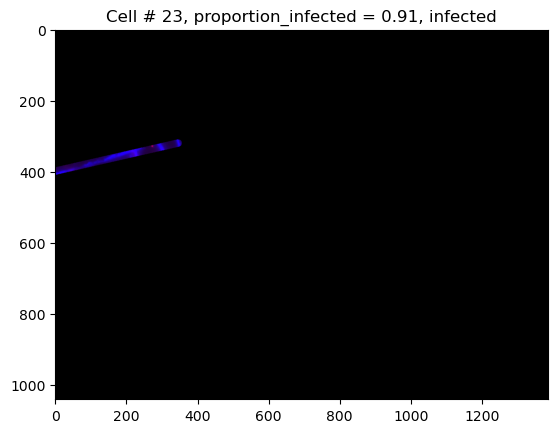

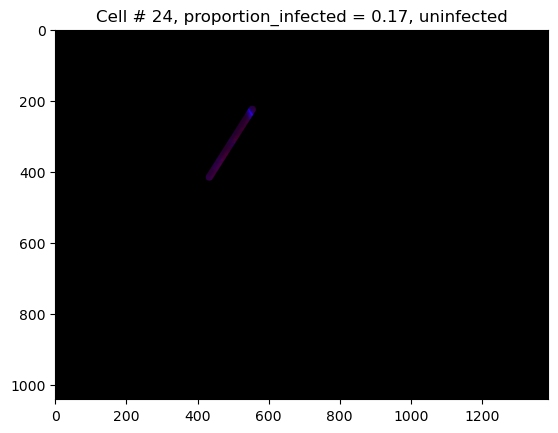

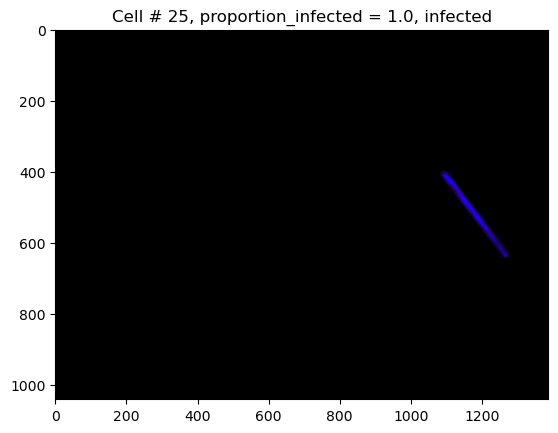

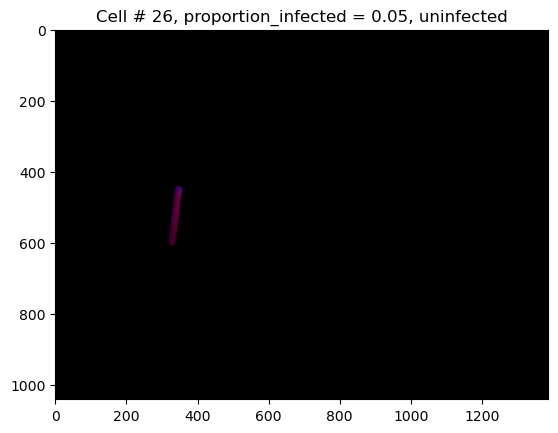

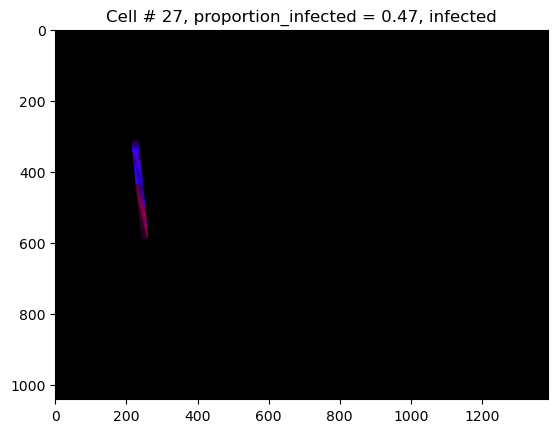

In [20]:
infected_cells,uninfected_cells=0,0
infection_threshold=0.2

for cell_number,line in enumerate(lines):
    subsetted_rgb=image_rgb.copy()
    temp_red=red_channel.copy()
    temp_blue=blue_channel.copy()
    target_coordinates={val:"" for val in all_coordinates[cell_number]}

    #Below creates a temporary plot (subsetted rgb) with all regions outside the range of the cell (target coordinates) replaced with black
    for i,row in enumerate(temp_red):
            for j,val in enumerate(row):
                if f"{i}_{j}" not in target_coordinates.keys():
                    temp_red[i][j]=0
                    temp_blue[i][j]=0
                    subsetted_rgb[i][j][0]=0
                    subsetted_rgb[i][j][1]=0
                    subsetted_rgb[i][j][2]=0
    proportion_infected=np.sum(temp_blue)/(np.sum(temp_red)+np.sum(temp_blue))
    plt.figure()
    plt.imshow(subsetted_rgb)
    if proportion_infected>=infection_threshold:
        is_infected="infected"
        infected_cells+=1
    else:
        is_infected="uninfected"
        uninfected_cells+=1
    plt.title(f"Cell # {cell_number}, proportion_infected = {round(proportion_infected,2)}, {is_infected}")

print(f"I count {infected_cells} infected and {uninfected_cells} uninfected cells.")

There are some cases where multiple cells are being merged into one longer cell - these are clear when a segmented cell transitions very abruptly between blue and red.  In principle we could avoid many of these cases by running line detection on the red and blue color channels separately, but this would also reduce our ability to detect cells in an "intermediate" infection state exhibiting a mix of colors.  From the few images I have seen such cells are quite rare anyways, so this may be a worthwhile endeavour.

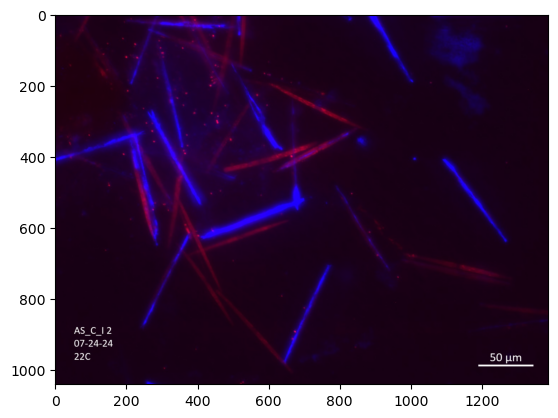

In [14]:
plt.imshow(image_rgb)

## Apply hough line approach to the other test images
I played around with skimage blob detection when attempting to remove the blue background noise in some of these later images, but regardless of the parameters used this approach always removed a chunk of the desirable cells as well.  As such I have implemented a quick, hacky solution to remove large clumps of pixels.  This just involves sliding a (here 30x30) window across the image and, if a region if found where almost all of the pixels are filled in, forcibly replacing these pixel values with 0. This helps to reduce some of the background noise, but is not a perfect solution - it reduces the true positive rate alongside the false positive rate.  Also, it is important that the window size (30) is larger than the cell width, to avoid removing cells.  Also, I am currently using the 95% quantile to set the threshold for the red and blue color channels.  This seems to work well for these few images, but a more nuanced approach may be needed when the whole dataset is used.

In [16]:
def remove_large_background(array,window_size,step_size,max_mean):
    clean_array=np.copy(array)
    for i in range(0,len(array)-window_size,step_size):
        for j in range(0,len(array[i])-window_size,step_size):    
            subset=array[i:i+window_size,j:j+window_size]
            if subset.mean()>max_mean:
                #print(i,j,file)
                clean_array[i:i+window_size,j:j+window_size]=0
    return clean_array
                    
for file in os.listdir("../data/images"):
    if file.endswith(".jpg"):
        print(file)
        
        image = cv2.imread(f"../data/images/{file}") 
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        red_channel = np.copy(image_rgb[:, :, 0])
        blue_channel = np.copy(image_rgb[:, :, 2])

        #apply threshold based on 95% quantile
        target_quantile=np.quantile(red_channel,0.95)
        red_channel[red_channel<target_quantile]=0
        red_channel[red_channel>=target_quantile]=255
        
        target_quantile=np.quantile(blue_channel,0.95)
        blue_channel[blue_channel<target_quantile]=0
        blue_channel[blue_channel>=target_quantile]=255


        blue_channel=remove_large_background(blue_channel,30,10,250)

        #make grayscale array
        custom_gray=[]
        for i,row in enumerate(red_channel):
            custom_gray.append([])
            for j,col in enumerate(row):
                if red_channel[i,j]>blue_channel[i,j]:
                    custom_gray[-1].append(red_channel[i,j]*255)
                else:
                    custom_gray[-1].append(blue_channel[i,j]*255)
        custom_gray=np.array(custom_gray).astype(np.uint8)
        
        backup=np.copy(image_rgb)
        image=cv2.resize(backup,(x_size, y_size))
        img = np.copy(cv2.resize(custom_gray,(x_size, y_size)))
        img=img*255
        
        edges = cv2.resize(custom_gray,(x_size, y_size))
        lines_list =[]
        #run line detection
        lines = cv2.HoughLinesP(
                    edges, # Input edge image
                    1, # Distance resolution in pixels
                    np.pi/180, # Angle resolution in radians
                    threshold=22, # Min number of votes for valid line
                    minLineLength=20, # Min allowed length of line
                    maxLineGap=5 # Max allowed gap between line for joining them
                    )
        
        
        for points in lines:
            x1,y1,x2,y2=points[0]
            cv2.line(image,(x1,y1),(x2,y2),(np.random.randint(50,255),np.random.randint(50,255),np.random.randint(50,255)),2)
            lines_list.append([(x1,y1),(x2,y2)])

        #get coordinates of detected lines
        all_coordinates=[]
        img=np.zeros((original_y_size, original_x_size),np.uint8)
        for line in lines:
            temp_red=red_channel.copy()
            temp_blue=blue_channel.copy()
            
            x1,y1,x2,y2=int(line[0][0]*original_y_size/y_size),int(line[0][1]*original_x_size/x_size),int(line[0][2]*original_y_size/y_size),int(line[0][3]*original_x_size/x_size)
            img=np.zeros((original_y_size, original_x_size),np.uint8)
            cv2.line(img,(x1,y1),(x2,y2),255,20)
            coords = np.argwhere(img) #returns coordinates of all non-zero pixels
            all_coordinates.append([f"{val[0]}_{val[1]}" for val in coords])

        print(f"I counted {len(lines)} cells.")
        
        print("Infection proportions are:")
        proportion_infected=[]
        for cell_number,line in enumerate(lines):
            subsetted_rgb=image_rgb.copy()
            temp_red=red_channel.copy()
            temp_blue=blue_channel.copy()
            target_coordinates={val:"" for val in all_coordinates[cell_number]}
            for i,row in enumerate(temp_red):
                    for j,val in enumerate(row):
                        if f"{i}_{j}" not in target_coordinates.keys():
                            temp_red[i][j]=0
                            temp_blue[i][j]=0
                            subsetted_rgb[i][j][0]=0
                            subsetted_rgb[i][j][1]=0
                            subsetted_rgb[i][j][2]=0
            proportion_infected.append(np.sum(temp_blue)/(np.sum(temp_red)+np.sum(temp_blue)))
        print(proportion_infected)
        print(f"I counted {len([val for val in proportion_infected if val>=infection_threshold])} infected and {len([val for val in proportion_infected if val<infection_threshold])} uninfected cells.")
        print()
        
 
        fig, ax = plt.subplots(1, 4, figsize=(13, 10))
        ax[0].imshow(image_rgb, cmap='magma')
        ax[1].imshow(custom_gray, cmap='magma')
        ax[2].imshow(edges, cmap='magma')
        ax[3].imshow(image, cmap='magma')
            # set the title to all subplots
        ax[0].set_title(file)
        ax[1].set_title("Grayscale Image")
        ax[2].set_title("Downsized grayscale Image")
        ax[3].set_title("Detected Lines")
        fig.tight_layout()

FileNotFoundError: [Errno 2] No such file or directory: '../data/images'

The segmentation is far from perfect and there are still several cases of cells being counted multiple times, which requires some downstream filtering of lines with similar start/endpoints and slopes.  If we proceed with this method, it will be very important to play with the HoughLinesP parameters on the whole dataset as these very strongly influence how many cells are returned.  I suspect that obtaining more accuracy might require the used of convolutional neural networks, which require a lot of training data and are also more computationally intensive to train.  In particular, the training data for this dataset would probably involve a lot of manually highlighting the regions corresponding to cells...